# Read Nearline data (ROOT) into pandas from ROOT files with NTuples and TH1s

## 1) Form a list of ROOT files in the target dir.

In [1]:
import os, re

target_dir = "../DATA/Nearline/" # TODO impliment as argparse in proper Python code 

#storage 
file_list=[] 
run_list=[]

# loop over files in the directroy 
for file in os.listdir(target_dir):
    file_name=file.replace(".", "_") # make all seperations the same 
    file_name_split=re.split('_', file_name) # split into e.g. "NearlinePlots", "30528", "root"
    if(file_name_split[0] == "NearlinePlots"): # check we got a correct file 
        run_list.append(file_name_split[1]) # form list of all runs 
        file_list.append(file) # ... of all files 

print("Found", len(file_list), "nearline files for runs:", *run_list) # "*" unpacked the list for print function

Found 2 nearline files for runs: 30528 30529


## 2) Loop over the file structure

In [2]:
# See https://github.com/scikit-hep/uproot for the manual 
import uproot # get this module by "python3 -m pip install uproot"

file = uproot.open(target_dir+"/"+file_list[0]) # load the ROOT file

top_dir = file["Nearline"] # look into top dir
folders_Tuple = top_dir.values() # list of sub-dirs and 1 NTuple 
print("\nIn top dir", *folders_Tuple)
folders = folders_Tuple[0:-1] # folders only have histograms (e.g. AllStations/Digits/hitTime)
print("\nFollowing folders found", folders)
ntuple = folders_Tuple[-1] # this is our single NTuple
trees=ntuple.keys()
print("\nFond trees in the NTuple", trees)

# TODO there are more and better ways to get TDir, and all objects etc. information see https://github.com/scikit-hep/uproot for the manual \
# TODO form a python dictionary of all availble histograms and Trees, use their names as "varialbes" for pandas storage 
# i.e. you shouldn't have to type them by hand 


In top dir <ROOTDirectory b'AllStations' at 0x000104c220d0> <ROOTDirectory b'station00' at 0x000104c224d0> <ROOTDirectory b'station12' at 0x000104c22850> <ROOTDirectory b'station18' at 0x000104c22a90> <TTree b'Info_ntup' at 0x0001049c9690>

Following folders found [<ROOTDirectory b'AllStations' at 0x000104c220d0>, <ROOTDirectory b'station00' at 0x000104c224d0>, <ROOTDirectory b'station12' at 0x000104c22850>, <ROOTDirectory b'station18' at 0x000104c22a90>]

Fond trees in the NTuple [b'gpsTime_first', b'gpsTime_first_frac', b'gpsTime_last', b'gpsTime_last_frac', b'nEvents', b'nDigits00', b'nDigits12', b'nDigits18', b'nCandidatesTotal00', b'nCandidatesTotal12', b'nCandidatesTotal18', b'nCandidatesPassQuality00', b'nCandidatesPassQuality12', b'nCandidatesPassQuality18', b'nTracksTotal00', b'nTracksTotal12', b'nTracksTotal18', b'nTracksPassQuality00', b'nTracksPassQuality12', b'nTracksPassQuality18', b'nVerticesTotal00', b'nVerticesTotal12', b'nVerticesTotal18', b'nVerticesPassQuality00', 

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://raw.githubusercontent.com/scikit-hep/uproot/master/docs/terminology.png", height=400)

## 3) Read one Histogram into pandas

In [4]:
#Simple code to read data (this should be done though forming dictionaries, see above)
import numpy as np

# Open a histogram 
hist=file["Nearline"+"/"+"AllStations"+"/"+"AllTime/Digits/hitTime"] # load histogram (again should be in a clever loop to avoid manually typing all histos names)
print("\nhist is a TH1F object", hist)

# the histogram in the numpy format (bin edges and frequencies)
hist_data_np = hist.numpy() 
print(hist_data_np)
counts, edges = hist_data_np[0], hist_data_np[1] # len(edges) = len(counts) + 1 
print("\nJust loaded", int(np.sum(counts)), "tracks !!! Overflows/Underflows not included!!!!")

# BONUS: the histogram in the pandas format (bin edges and frequencies)
hist_data = hist.pandas()
hist_data # nice printing only works in JupyetLab (use print() in the .py file https://stackoverflow.com/questions/38487945/how-to-print-a-df-in-terminal-without-loosing-format)


hist is a TH1F object <b'TH1F' b'hitTime' 0x000104be1470>
(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0.00000000e+00, 1.48936000e-01, 2.97872000e-01, ...,
       5.95446128e+02, 5.95595064e+02, 5.95744000e+02]))

Just loaded 16 tracks !!! Overflows/Underflows not included!!!!


,count,variance
"[-inf, 0.0)",0.0,0.0
"[0.0, 0.148936)",0.0,0.0
"[0.148936, 0.297872)",0.0,0.0
"[0.297872, 0.44680800000000004)",0.0,0.0
"[0.44680800000000004, 0.595744)",0.0,0.0
...,...,...
"[595.1482560000001, 595.297192)",0.0,0.0
"[595.297192, 595.446128)",0.0,0.0
"[595.446128, 595.5950640000001)",0.0,0.0
"[595.5950640000001, 595.744)",0.0,0.0


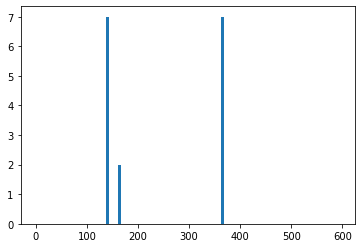

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
binW=edges[1] - edges[0] # fndd bin wdith 
binC=np.linspace(edges[0]+binW/2, edges[-1]-binW/2, len(counts)) # form array of bin centeres
plt.hist(binC, weights=counts, bins=100);# plot our historgram 

## 4) Read NTuple

In [6]:
# Open a Tree
branch=ntuple["gpsTime_first"] # load a brnach (again should be in a clever loop to avoid manually typing all tuple names)
print("\nbranch is a TBranch object", branch)

# look into branch
print("Total enties", branch.numentries)

#load into array
a=branch.array()
print(a)


branch is a TBranch object <TBranch b'gpsTime_first' at 0x000104c22b90>
Total enties 3
[1575757867 1575757884 1575757900]


In [7]:
# BONUS: Alternative way to get ALL data from Tuples/Trees is with (requires ROOT linking to Python!)
import sys,os
sys.path.append(os.environ["JUPYROOT"]) # where JUPYROOT is path to ROOT e.g. /usr/local/Cellar/root/6.18.04/lib/root
# for Python3 install root_numpy with "python3 -m pip install --user root_numpy"
import root_numpy # see http://scikit-hep.org/root_numpy/install.html  
# for Python3 install root_pandas with "python3 -m pip install --user root_pandas"
from root_pandas import read_root # see https://github.com/scikit-hep/root_pandas 

data = read_root(target_dir+file_list[0], 'Nearline/Info_ntup')
data

Welcome to JupyROOT 6.18/04


,gpsTime_first,gpsTime_first_frac,gpsTime_last,gpsTime_last_frac,nEvents,nDigits00,nDigits12,nDigits18,nCandidatesTotal00,nCandidatesTotal12,...,nTracksTotal18,nTracksPassQuality00,nTracksPassQuality12,nTracksPassQuality18,nVerticesTotal00,nVerticesTotal12,nVerticesTotal18,nVerticesPassQuality00,nVerticesPassQuality12,nVerticesPassQuality18
0,1575757867,568286498,1575757883,4294065096,100,0,7,7,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1575757884,1101991198,1575757900,3204369788,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1575757900,3247361033,1575757928,1841578255,95,0,9,9,0,0,...,0,0,0,0,0,0,0,0,0,0


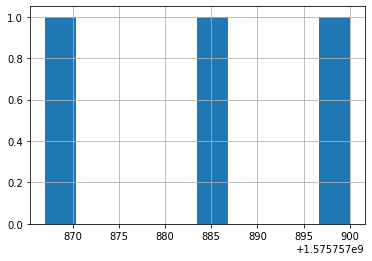

In [8]:
data["gpsTime_first"].hist();